# DEEPLY PEEVED: Neural Nets for Volcano Prediction


In [1]:
import numpy as np
from util import load_hypocenters, PuuOo, load_puuoo_eqs, GetTimeToEruption, GetTimeSinceEruption, GetEQRates
from matplotlib import pyplot as plt
import datetime
from sklearn import ensemble as ml_models
from sklearn import metrics
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim

%matplotlib inline

## Prepare dataset/dataloader

In [2]:
from __future__ import absolute_import, print_function

import os
import os.path as osp
from glob import glob

import numpy as np
import random
import scipy.io as sio
import torch
from torch.utils import data
from sklearn.preprocessing import StandardScaler
from util import load_hypocenters, PuuOo, load_puuoo_eqs


class BaseEarthquakes(data.Dataset):
    """Earthquake and Eruption Dataset"""

    def __init__(self, root, eruption_csv_path, eq_csv_path, split):
        self.root  = root
        self.split = split
        self.eruption_csv_path = eruption_csv_path
        self.eq_csv_path = eq_csv_path
        self._get_east_rift_zone()
        self._load_data()

        self._normalize()
        
    def _get_east_rift_zone(self): 
        self.p = PuuOo(self.eruption_csv_path)
        time, lat, lon, depth, mag = load_puuoo_eqs(self.eq_csv_path)
        
        latpts = np.array([19.3,19.5])
        lonpts = np.array([-155.5,-155])
        A      = np.array([lonpts,[1,1]]).T
        line   = np.linalg.solve(A, latpts)   
        croplocs = lat - line[0]*lon - line[1]        
        idx = [j for j in range(len(lon)) if croplocs[j]<=0]
        
        self.time = np.array(time)[idx]
        self.lat = np.array(lat)[idx]
        self.lon = np.array(lon)[idx]
        self.depth = np.array(depth)[idx]
        self.mag = np.array(mag)[idx]
        
        print(len(idx))
    
    def _normalize(self):
        scaler = StandardScaler()
        scaler.fit(self.x)
        self.x = scaler.transform(self.x)
    
    def _load_data(self):
        # Create data list via train, val split

        if self.split in ["train", "val", "test"]:
            random.seed(0)
            percent_train = 0.7 
            percent_dev   = 0.2 # Percent test is what is left
            
            # Make additional array for erupting or not
            erupt = np.array([self.p.was_erupting(t) for t in self.time])
            
            # Get indices of eruption and non-eruption earthquakes so we can split both
            eruption_idx    = [i for i, e in enumerate(erupt) if e == True]
            no_eruption_idx = [i for i, e in enumerate(erupt) if e == False]

            num_train_eruptions = int(percent_train * len(eruption_idx))
            num_val_eruptions   = int(percent_dev * len(eruption_idx))
            num_test_eruptions  = len(eruption_idx) - num_val_eruptions - num_train_eruptions

            num_train_no_eruptions = int(percent_train * len(no_eruption_idx))
            num_val_no_eruptions   = int(percent_dev * len(no_eruption_idx))
            num_test_no_eruptions  = len(no_eruption_idx) - num_val_no_eruptions - num_train_no_eruptions
            
            train_idx = sorted(random.sample(eruption_idx, num_train_eruptions))
            remaining = sorted(list(set(eruption_idx) - set(train_idx)))
            val_idx   = sorted(random.sample(remaining, num_val_eruptions))
            test_idx  = sorted(list(set(remaining) - set(val_idx)))
            
            train_idx += sorted(random.sample(no_eruption_idx, num_train_no_eruptions))
            remaining  = sorted(list(set(no_eruption_idx) - set(train_idx)))
            val_idx   += sorted(random.sample(remaining, num_val_no_eruptions))
            test_idx  += sorted(list(set(remaining) - set(val_idx)))
            
            print(len(train_idx))
            print(len(val_idx))
            print(len(test_idx))
            print(len(train_idx) + len(val_idx) + len(test_idx))
            print(len(erupt))
            
            assert(len(train_idx) + len(val_idx) + len(test_idx) == len(erupt))
            
            if self.split == "train":
                idx = train_idx
            elif self.split == "val":
                idx = val_idx
            elif self.split == "test":
                idx = test_idx
            
            # Shuffle for data loader
            
            random.shuffle(idx)
            self.idx = idx
            
            self.time = self.time[idx]
            self.lat = self.lat[idx]
            self.lon = self.lon[idx]
            self.depth = self.depth[idx]
            self.mag = self.mag[idx]
            self.erupt = erupt[idx]
            
            self.y = self.erupt
            self.x = np.array([self.lat, self.lon, \
                               self.depth, self.mag]).T
            
        else:
            raise ValueError("Invalid split name: {}".format(self.split))

    def _get_label_weights(self):
        # Get weights for a given dataset
        num_erupt = np.sum(self.y)
        total = len(self.y)
        weights = [1, total/num_erupt]

        return weights
    
    def __getitem__(self, index):
        raise NotImplementedError
        
    def __len__(self):
        return len(self.erupt)

class NoDerivedFeatures(BaseEarthquakes):
    
    def __init__(self, **kwargs):
        super(NoDerivedFeatures, self).__init__(**kwargs)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
        
class ExtraFeatures(BaseEarthquakes):
    
    def __init__(self, **kwargs):
        super(ExtraFeatures, self).__init__(**kwargs)
        self.derive_extra_features()
        self._normalize()
    
    def derive_extra_features(self):
        self.SecsToEruption = GetTimeToEruption(self.time, self.p)
        self.SecsSinceEruption = GetTimeSinceEruption(self.time, self.p)
        self.EQsLastDay, self.EQsLastWeek, self.EQsLastMonth = GetEQRates(self.time)
        self.x = np.hstack((self.x, self.EQsLastMonth[:,np.newaxis]))
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]


    

In [3]:
eruption_csv_path = 'PuuOo.csv'
eq_csv_path       = 'puuoo_earthquakes.csv' 

dataset_train = ExtraFeatures(
        root=".",
        eruption_csv_path=eruption_csv_path, 
        eq_csv_path=eq_csv_path,    
        split="train",
    )

dataset_val = ExtraFeatures(
        root=".",
        eruption_csv_path=eruption_csv_path, 
        eq_csv_path=eq_csv_path,    
        split="val",
    )

dataset_test = ExtraFeatures(
        root=".",
        eruption_csv_path=eruption_csv_path, 
        eq_csv_path=eq_csv_path,    
        split="test",
    )


loader_train = DataLoader(dataset_train, batch_size=50)
loader_val = DataLoader(dataset_val, batch_size=50)
loader_test = DataLoader(dataset_test, batch_size=50)


3764
2633
752
379
3764
3764
3764
2633
752
379
3764
3764
3764
2633
752
379
3764
3764


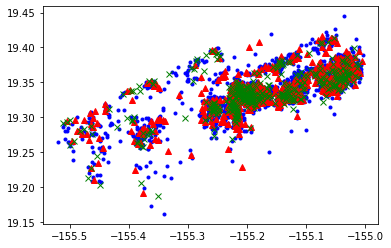

In [4]:
plt.figure()
plt.plot(dataset_train.lon, dataset_train.lat, 'b.', label='training')
plt.plot(dataset_val.lon, dataset_val.lat, 'r^', label='dev')
plt.plot(dataset_test.lon, dataset_test.lat, 'gx', label='test')

In [ ]:
np.array(dataset_train.idx)

In [ ]:
np.savetxt('train.txt', sorted(dataset_train.idx), '%d')
np.savetxt('dev.txt', sorted(dataset_val.idx), '%d')
np.savetxt('test.txt', sorted(dataset_test.idx), '%d')


## Build Model

In [ ]:
def get_two_layer_model(input_features, hidden_layer_sizes=[1000,500], output_size=1):

    model = nn.Sequential(
        nn.Linear(input_features, hidden_layer_sizes[0]),
        nn.ReLU(),
        nn.Linear(hidden_layer_sizes[0], hidden_layer_sizes[1]),
        nn.ReLU(),
        nn.Linear(hidden_layer_sizes[1],output_size)
    )
    
    return model.double()

def get_four_layer_model(input_features, hidden_layer_sizes=[1000,1000,1000,1000], output_size=1):

    model = nn.Sequential(
        nn.Linear(input_features, hidden_layer_sizes[0]),
        nn.ReLU(),
        nn.Linear(hidden_layer_sizes[0], hidden_layer_sizes[1]),
        nn.ReLU(),
        nn.Linear(hidden_layer_sizes[1], hidden_layer_sizes[2]),
        nn.ReLU(),
        nn.Linear(hidden_layer_sizes[2], hidden_layer_sizes[3]),
        nn.ReLU(),
        nn.Linear(hidden_layer_sizes[3],output_size),
    )
    
    return model.double()


In [ ]:
model = get_four_layer_model(4)
print(model.modules)

## Train!

In [71]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    num_pos     = 0
    predicted   = []
    val_label   = []
    
    with torch.no_grad():
        
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = torch.nn.functional.sigmoid(model(x))
            
            preds = torch.squeeze((scores > 0.5).long())

            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            num_pos += (preds).sum()
            
            predicted += preds.tolist()
            val_label += y.tolist()
            
        acc = float(num_correct) / num_samples
        print('Accuracy on ' + loader.dataset.split + ': Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        print(metrics.confusion_matrix(val_label, predicted))
        print('Kappa:', metrics.cohen_kappa_score(val_label, predicted))
        print('AUROC:', metrics.roc_auc_score(val_label, predicted))
        print('Num pos: %d' % num_pos)
        
def train_model(model, optimizer, epochs=1):
    
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    
    weights = loader_train.dataset._get_label_weights()
    weights = torch.tensor(weights)
    print('Weghts are: ', weights)
    #criterion = nn.CrossEntropyLoss(weight=weights.double())
    #criterion = nn.BCEWithLogitsLoss(pos_weight=weights[1])
    criterion = nn.BCEWithLogitsLoss()
    criterion.to(device)

    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            
            y = torch.unsqueeze(y,1)
           
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
                    
            scores = model(x)
            loss = criterion(scores.float(), y.float())

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

        if e % print_every == 0:
            print('Epoch %d, loss = %.4f' % (e, loss.item()))
            check_accuracy(loader_train, model)
            check_accuracy(loader_val, model)
            check_accuracy(loader_test, model)
            print()

In [73]:
learning_rate = 0.05
weight_decay  = 0.001
print_every = 150

device = torch.device('cuda')
dtype = torch.float64

#two_layer_model = get_two_layer_model(5)
optimizer = optim.SGD(two_layer_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_model(two_layer_model, optimizer, epochs=1000)

Weghts are:  tensor([1.0000, 4.4627])
Epoch 0, loss = 0.5598
Accuracy on train: Got 2160 / 2633 correct (82.04)
[[2024   19]
 [ 454  136]]
Kappa: 0.29981475078499
AUROC: 0.6106042128143225
Num pos: 155
Accuracy on val: Got 603 / 752 correct (80.19)
[[577   7]
 [142  26]]
Kappa: 0.200022846698652
AUROC: 0.5713878016960209
Num pos: 33
Accuracy on test: Got 306 / 379 correct (80.74)
[[292   1]
 [ 72  14]]
Kappa: 0.22499229670298881
AUROC: 0.5796888641955711
Num pos: 15

Epoch 150, loss = 0.5135
Accuracy on train: Got 2201 / 2633 correct (83.59)
[[2022   21]
 [ 411  179]]
Kappa: 0.3831817664188454
AUROC: 0.646555414520023
Num pos: 200
Accuracy on val: Got 603 / 752 correct (80.19)
[[560  24]
 [125  43]]
Kappa: 0.2733969703257938
AUROC: 0.607428245270711
Num pos: 67
Accuracy on test: Got 312 / 379 correct (82.32)
[[288   5]
 [ 62  24]]
Kappa: 0.34209912687514565
AUROC: 0.6310024605127391
Num pos: 29

Epoch 300, loss = 0.4966
Accuracy on train: Got 2202 / 2633 correct (83.63)
[[2019   24]
 [

In [21]:
print(np.sum(1-loader_train.dataset.y)/len(loader_train.dataset.y))
print(np.sum(1-loader_val.dataset.y)/len(loader_val.dataset.y))


0.8095238095238095
0.8089368258859785


In [80]:
learning_rate = 0.02
weight_decay  = 0.01
print_every = 50

device = torch.device('cuda')
dtype = torch.float64

four_layer_model = get_four_layer_model(5)
optimizer = optim.SGD(four_layer_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_model(four_layer_model, optimizer, epochs=1000)

Weghts are:  tensor([1.0000, 4.4627])
Epoch 0, loss = 0.5829
Accuracy on train: Got 2043 / 2633 correct (77.59)
[[2043    0]
 [ 590    0]]
Kappa: 0.0
AUROC: 0.5
Num pos: 0
Accuracy on val: Got 584 / 752 correct (77.66)
[[584   0]
 [168   0]]
Kappa: 0.0
AUROC: 0.5
Num pos: 0
Accuracy on test: Got 293 / 379 correct (77.31)
[[293   0]
 [ 86   0]]
Kappa: 0.0
AUROC: 0.5
Num pos: 0

Epoch 50, loss = 0.5559
Accuracy on train: Got 2171 / 2633 correct (82.45)
[[2025   18]
 [ 444  146]]
Kappa: 0.3210895197018354
AUROC: 0.6193235272157098
Num pos: 164
Accuracy on val: Got 608 / 752 correct (80.85)
[[576   8]
 [136  32]]
Kappa: 0.24261414503133405
AUROC: 0.588388780169602
Num pos: 40
Accuracy on test: Got 304 / 379 correct (80.21)
[[290   3]
 [ 72  14]]
Kappa: 0.2128873258937224
AUROC: 0.5762758949122947
Num pos: 17

Epoch 100, loss = 0.5407
Accuracy on train: Got 2177 / 2633 correct (82.68)
[[2027   16]
 [ 440  150]]
Kappa: 0.33099158172987986
AUROC: 0.6232028339845856
Num pos: 166
Accuracy on va

KeyboardInterrupt: 

## Now for regression problem

In [4]:
class TimeDS(BaseEarthquakes):
    
    def __init__(self, **kwargs):
        super(TimeDS, self).__init__(**kwargs)
        self.derive_extra_features()
        self._normalize()
    
    def derive_extra_features(self):
        self.SecsToEruption = GetTimeToEruption(self.time, self.p)
        self.SecsSinceEruption = GetTimeSinceEruption(self.time, self.p)
        self.EQsLastDay, self.EQsLastWeek, self.EQsLastMonth = GetEQRates(self.time)
        self.x = np.hstack((self.x, self.EQsLastMonth[:,np.newaxis]))
        self.y = self.SecsToEruption.reshape((-1,1))
        scaler = StandardScaler()
        scaler.fit(self.y)
        self.y = scaler.transform(self.y)
        
    def __getitem__(self, index):
     
        return self.x[index], self.y[index]



In [5]:
eruption_csv_path = 'PuuOo.csv'
eq_csv_path       = 'puuoo_earthquakes.csv' 

dataset_train = TimeDS(
        root=".",
        eruption_csv_path=eruption_csv_path, 
        eq_csv_path=eq_csv_path,    
        split="train",
    )

dataset_val = TimeDS(
        root=".",
        eruption_csv_path=eruption_csv_path, 
        eq_csv_path=eq_csv_path,    
        split="val",
    )

dataset_test = TimeDS(
        root=".",
        eruption_csv_path=eruption_csv_path, 
        eq_csv_path=eq_csv_path,    
        split="test",
    )


loader_train = DataLoader(dataset_train, batch_size=50)
loader_val = DataLoader(dataset_val, batch_size=50)
loader_test = DataLoader(dataset_test, batch_size=50)

3764
2633
752
379
3764
3764
3764
2633
752
379
3764
3764
3764
2633
752
379
3764
3764


In [6]:
def get_two_layer_time_model(input_features, hidden_layer_sizes=[1000,500], output_size=1):

    model = nn.Sequential(
        nn.Linear(input_features, hidden_layer_sizes[0]),
        nn.ReLU(),
        nn.Linear(hidden_layer_sizes[0], hidden_layer_sizes[1]),
        nn.ReLU(),
        nn.Linear(hidden_layer_sizes[1],output_size),
    )
    
    return model.double()

def get_four_layer_time_model(input_features, hidden_layer_sizes=[1000,1000,1000,1000], output_size=1):

    model = nn.Sequential(
        nn.Linear(input_features, hidden_layer_sizes[0]),
        nn.ReLU(),
        nn.Linear(hidden_layer_sizes[0], hidden_layer_sizes[1]),
        nn.ReLU(),
        nn.Linear(hidden_layer_sizes[1], hidden_layer_sizes[2]),
        nn.ReLU(),
        nn.Linear(hidden_layer_sizes[2], hidden_layer_sizes[3]),
        nn.ReLU(),
        nn.Linear(hidden_layer_sizes[3],output_size),
    )
    
    return model.double()

In [9]:
def check_accuracy(loader, model, criterion):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    num_pos     = 0
    predicted   = []
    val_label   = []
    
    with torch.no_grad():
        
        num_total = 0
        total_loss = 0
        
        for x, y in loader:
          
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)
            
            num_batch = x.shape[0]
            num_total += num_batch
            
            scores = model(x)
            loss = criterion(scores.float(), y.float())
            
            total_loss += loss.item() * num_batch  
            
            
        average_loss = np.sqrt(total_loss/num_total)
        print(('RMSE on ' + loader.dataset.split + ": %.2f") % average_loss)

def train_model(model, optimizer, epochs=1):
    
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    
    criterion = nn.MSELoss()
    criterion.to(device)

    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
          
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)
                    
            scores = model(x)
            loss = criterion(scores.float(), y.float())

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

        if e % print_every == 0:
            print('Epoch %d, loss = %.4f' % (e, loss.item()))
            check_accuracy(loader_train, model, criterion)
            check_accuracy(loader_val, model, criterion)
            check_accuracy(loader_test, model, criterion)

In [10]:
learning_rate = 0.001
weight_decay  = 0.00001
print_every = 150

device = torch.device('cuda')
dtype = torch.float64

two_layer_model = get_two_layer_time_model(5)
optimizer = optim.SGD(two_layer_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_model(two_layer_model, optimizer, epochs=10000)

Epoch 0, loss = 0.5985
RMSE on train: 0.95
RMSE on val: 0.95
RMSE on test: 0.95
Epoch 150, loss = 0.4702
RMSE on train: 0.87
RMSE on val: 0.92
RMSE on test: 0.91
Epoch 300, loss = 0.4430
RMSE on train: 0.86
RMSE on val: 0.92
RMSE on test: 0.90


KeyboardInterrupt: 

In [11]:
# Make plots of pred v. actual
def get_preds(loader, model):

    predicted   = []
    val_label   = []
    
    with torch.no_grad():
   
        for x, y in loader:
          
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)
            
            scores = model(x)
            
            predicted += scores.tolist()
            val_label += y.tolist()
    
    return predicted, val_label
        


In [18]:
predicted, actual = get_preds(loader_test, two_layer_model)

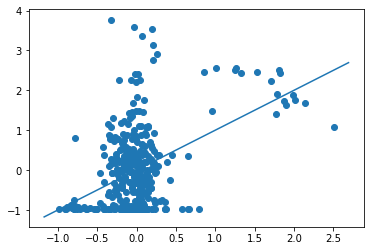

In [19]:
plt.scatter(predicted, actual)
left, right = plt.xlim()
plt.plot([left, right], [left,right])
plt.show()


In [20]:
metrics.r2_score(actual, predicted)

0.18577904409003854